# Solving the Traveling Salesman Problem with Genetic Algorithms
- **Andrew Gibson,** 8/23/25
- COGS 186: Genetic Algorithms
- Prof. Anjum Gupta

The traveling salesman problem (TSP) is a classical combinatorial optimization problem, defined as “Given a list of cities and the distances between each pair of cities, what is the shortest possible route that visits each city and returns to the origin city?”

Its complexity scales exponentially with the number of cities. For n cities, there are $(n-1)!/2$ possible combinations.

![picture](traveling_salesman.png)

Illustration of a potential solution to the Traveling Salesman Problem.

Our algorithm must adhere to two basic rules:
- Each city needs to be visited exactly once
- We must return to the starting city, so our total distance needs to be calculated accordingly  
### Approach:
We can reconfigure our genetic algorithm in the context of the TSP:
- Gene: a city (represented as (x, y) coordinates)
- Individual (aka “chromosome”): a single route satisfying the conditions above
- Population: a collection of possible routes (i.e., a collection of individuals)
- Parents: two routes that are combined to create a new route
- Mating pool: a collection of parents that are used to create our next population (thus creating the next generation of routes)
- Fitness: a function that tells us how good each route is (in our case, how short the distance is)
- Mutation: a way to introduce variation in our population by randomly swapping two cities in a route
- Elitism: a way to carry the best individuals into the next generation    
  
This my general flow for applying GA to the TSP:
- 1. Create the population
- 2. Determine fitness
- 3. Select the mating pool
- 4. Breed
- 5. Mutate
- 6. Repeat  

In [1]:
# ! conda info

In [2]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt
import matplotlib.animation as animation
import time

np.random.seed(186)

In [3]:
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance
    
    def __repr__(self):
        
        return "(" + str(self.x) + "," + str(self.y) + ")"

In [4]:
class Fitness:
    def __init__(self, route):
        self.route = route # will be a list of cities
        self.distance = 0
        self.fitness = 0.0
    
    def routeDistance(self):
        # i added similar features for edge cases like i did in A1
        if self.route is None or len(self.route) == 0: # safety against empty or 0 input for route
            self.distance = float('inf') # make distance infinite so fitness -> 0
            return self.distance

        if self.distance == 0: # ensures this is the first time it calculates distance
            pathDistance = 0
            for i in range(0, len(self.route)): # loop through length of route
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route): # loop through every city until we get to the last
                    toCity = self.route[i + 1] # move to the next stop
                else: # add the distance back to the starting city
                    toCity = self.route[0] # collect the distance between the last city and the first city
                pathDistance += fromCity.distance(toCity)

            if pathDistance <= 0.0:
                pathDistance = float('inf') # avoid divide by zero issues and heavily penalize bad routes
            self.distance = pathDistance # store the distance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance()) # The longer the route, the lower the fitness
            
        return self.fitness

In [5]:
def createRoute(cityList):
    """
    Creates a random individual and in the case of TSP: a route.
    
    input: None
    output: A list of City class objects. 
    """
    route = random.sample(cityList, len(cityList))
    
    return route

In [6]:
def initialPopulation(popSize, cityList):
    """
    Create inital population of a given size.
    Returns a list of random planes.
    """
    population = []

    for _ in range(popSize):
        population.append(createRoute(cityList))
        
    return population

In [7]:
def rankRoutes(population):
    """
    This function sorts the given population in decreasing order of the fitness score.
    Returns a list of ordered pairs of (index, fitness) where index is the index of the
    individual within the population
    """
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
        
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

In [8]:
def selection(popRanked, eliteSize):
    """
    popRanked: output of rankpopulation() or for this problem: rankRoutes()
    eliteSize: number of highest ranked individuals we will retain in the next generation.
    
    This function takes in a population sorted in decreasing order of fitness score, and chooses a mating pool from it.
    It returns a list of indices of the chosen mating pool in the given population.
    """
    selectionResults = []
    
    # step 1: Retaining the individuals of the top-eliteSize-best fitness in the population.
    N = len(popRanked)
    eliteSize = max(0, min(int(eliteSize), N))  # clamping and casting for safety
    
    ix_elite = [ix for ix, _ in popRanked[0:eliteSize]] # sample the top x elite individuals
    
    selectionResults.extend(ix_elite) # automatically add elites to results
    
    # step 2: sample from the rest using the fitness-proportionate selection
    # step 2.1: convert fitness to weight
    indices, fitness = zip(*popRanked[eliteSize:])
    weights = np.array(fitness) / np.sum(fitness)
    # step 2.2: weighted sampling
    n_remain = N - eliteSize

    sampled = np.random.choice(indices, size=n_remain, p=weights)
    # p = the probability associated with each entry = fitnesses as fractions of total fitness
    # b/c of their weights more fit individuals are more likely to be selected

    selectionResults.extend(sampled.tolist()) # add sampled to the results
    # will return a list of indicies of len N (same as the initial population)
    
    return selectionResults

In [9]:
def matingPool(population, selectionResults):
    """
    Create the mating pool.
    Returns a list Planes that has been selected. 
    """
    matingpool = [population[i] for i in selectionResults]
    return matingpool

### Crossover and Mutation
There are infinite crossover and mutation functions one could use for genetic algorithms. I picked ordered crossover because I thought it 
could be helpful to preserve the order of good routes. I've tested several other crossover functions, one of which is commented out below, with noticable, but largely marginal differences.

![picture](parent_child.png)
(src: http://dtnewman.github.io/finch/genetic_algorithms.html)

See my genetic algorithm notebook for more options for breeding and mutation functions.

In [10]:
def breed(parent1, parent2):
    """
    ~ New Ordered Crossover Function for TSP ~
    This function should breed both parents (routes) and return a child route according to the ordered crossover algorithm  
    mentioned above. Please fill in the code to do so. Creates a copy of a continuous slice of DNA from the genome of parent 1. The
    remaining positions are filled in using DNA from parent 2.
    """
    N = len(parent1) # get the num of genes (cities) from either parent
    
    # step 1: select and copy the subset from parent 1

    # np.random.choice picks two random cut points on interval [0, n) for crossover
    # np.sort forces the start position to be before the stop position on the genome
    start, stop = np.sort(np.random.choice(N, size=2, replace=False))
    # preallocates N empty spots to store genes later
    child = [None] * N # this allows us to index instead of using .extend which would mess up the position
    child[start:stop] = parent1[start:stop] # duplicate segment into child at the same indices
    
    # step 2: fill the remaining positions with genes from parent 2
    w = stop
    # loop through parent2 from stop to the end and then wrap around to the beginning
    for i in list(parent2[stop:]) + list(parent2[:stop]): # where i = each city
        if i not in child: # each city must be visited exactly once
            child[w % N] = i # when w == N then we wrap around back to the start
            w += 1 # iterate through filling the remaining slots
    
    return child

In [11]:
# alternate breeding function
# def breed(parent1, parent2):
#     N = len(parent1)
#     start, stop = np.sort(np.random.choice(N, 2, replace=False))
#     child = [None] * N
#     child[start:stop] = parent1[start:stop]
#     j = stop
#     for city in parent2[stop:] + parent2[:stop]:
#         if city not in child:
#             child[j % N] = city
#             j += 1
#     return child

In [12]:
def breedPopulation(matingpool, eliteSize):
    """
    This function should return the offspring population from the current population using the breed function. 
    - First, it should retain the eliteSize best routes from the current population. 
    - Then, it should use the breed function to mate members of the population, to fill out the rest of the next generation. 
    You have the freedom to decide how to sample individuals from the mating pool for mating.
    """
    N = len(matingpool)
    assert eliteSize <= N, "Error: eliteSize > N"
    eliteSize = max(0, min(int(eliteSize), N)) # clamp and cast same as before

    children = []

    # first, automatically breed elites
    children.extend([tour[:] for tour in matingpool[:eliteSize]])

    # second, create the remaining children from random parents
    for i in range(N - eliteSize): # loop through the remaining slots in population
        # same as previous GA: some parents will produce multiple children and some none at all
        parent1 = matingpool[np.random.randint(N)] # randomly sample matingpool uniformly and with replacement
        parent2 = matingpool[np.random.randint(N)]

        child = breed(parent1, parent2) # call breed function on mating pair
        children.append(child) # add new child to the list of new children

    # safety check to make sure population size stays constant with each iteration
    assert len(children) == N, "Error: length of children != N"

    return children

In [13]:
# def mutate(individual, mutationRate):
#     """
#     ~ Swap Mutation Function for TSP ~
#     This function should take in an individual (route) and return a mutated individual. Assuming mutationRate is a probability
#     between 0 and 1. Use the swap mutation described above to mutate the individual according to the mutationRate. Iterate 
#     through each of the cities and swap it with another city according to the given mutationRate. Hypothetically, the average number of 
#     swap mutations per run of this function will be equal to N * mutationRate.

#     returns : list of mutated tours or original list unchanged
#     """
#     N = len(individual)
#     ix = list(range(N)) # create an ix map so we can rearrange ixs instead of changing the original tour
#     # this allows us to just reorder the ixs instead of mutating the actual list of routes
    
#     for i in range(N): # loop through each position in tour
#         if np.random.rand() < mutationRate: # randomly decide whether or not to mutate position i
#             j = np.random.randint(N - 1) # if mutate, pick random position j
#             # j will be uniform over all indicies except i
            
#             if j >= i: # make sure i and j are not equal so we are swapping two unique positions
#                 j += 1 # skip over i when j is at or after i to avoid i picking itself
#             # do the swap every time function chooses to mutate
#             ix[i], ix[j] = ix[j], ix[i] # use the ix map to swap the two unique cities

#     # build new tour
#     #tour = [individual[k] for k in ix] # reindex original individual using (potentially mutated) ix map
    
#     return [individual[k] for k in ix]

In [14]:
# batch mutation function that hopefully avoids issues with my original one
def mutate(individual, mutationRate):
    """
    ~ Alternate (Batch) Mutation Function for TSP ~
    Hopefully rectifies issues associated with my first function. In TSP and other optimization problems, mutation helps avoid local 
    convergence.
    """
    N  = len(individual)
    ix = list(range(N))

    mask = np.random.rand(N) < mutationRate # boolean mask to choose which positions to select for mutation
    position = [p for p in range(N) if mask[p]] # list comp to extract True indicies from the mask

    if len(position) >= 2: # b/c we need at least 2 positions in order to perform a swap
        # random order, then rotate so no one stays in place
        np.random.shuffle(position) # shuffle the position's order randomly
        position_rot = position[1:] + position[:1] # move every item in the list one position to the left and wrap around
        # each position should be paired with the next position in the cycle
        for a, b in zip(position, position_rot):
            ix[a], ix[b] = ix[b], ix[a]

    return [individual[k] for k in ix]

In [15]:
# ## different type of mutation function for fun
# def mutate_2opt(individual, mutationRate):
#     tour = individual[:]
    
#     if np.random.rand() < mutationRate:
#         start, stop = sorted(np.random.choice(len(tour), 2, replace=False))
#         tour[start:stop+1] = reversed(tour[start:stop+1])
#     return tour

In [16]:
def mutatePopulation(population, mutationRate, eliteSize):
    """
    This function uses the above mutate function to mutate each member of the population. It iterates over the population and 
    mutates each individual using the mutationRate. It then returns the mutated population.
    """
    N = len(population)
    assert eliteSize <= N, "Error: eliteSize > N"
    eliteSize = max(0, min(int(eliteSize), N)) # make sure eliteSize isn't greater than population
    
    mutatedPop = []
    # step 1: retain all elites
    # automatically transfer all elites into the new population unchanged
    # tour[:] shallow copies a new list with the same cities, so we can't accidently change elite's order later
    mutatedPop.extend([tour[:] for tour in population[:eliteSize]]) # select elites and add them to mutatedPop
    
    # step 2: mutate those that are not the elites
    for i in population[eliteSize:]: # for the rest of the population
        mutatedPop.append(mutate(i, mutationRate)) # decide whether to mutate and add each to mutatedPop

    # redundant safety checks given issues I had with first GA
    assert len(mutatedPop) == N, "Error: mutatedPop != N"
    
    return mutatedPop

In [17]:
def nextGeneration(currentGen, eliteSize, mutationRate):
    """
    This function takes in the current generation, eliteSize and mutationRate and should returns the next generation.
    """
    # step 1, rank given population according to fitness
    ranked_pop = rankRoutes(currentGen)

    # step 2, proportional selection with elitism
    select_ixs = selection(ranked_pop, eliteSize)

    # step 3, call matingPool function to create a new list of tours based on selected ixs
    mate_pool = matingPool(currentGen, select_ixs)

    # step 4, use pool to breed new population of children of same size N
    child_pool = breedPopulation(mate_pool, eliteSize)

    # step 5, randomly decide whether or not to mutate non elite tours
    nextGeneration = mutatePopulation(child_pool, mutationRate, eliteSize)

    return nextGeneration

#### Main driver function
Parameters:
1. `population`: A list of possible genes. In our case, a list of all `City`s. 
2. `popSize`: The population size at each generation. 
3. `eliteSize`: The size of the elite population. 
4. `mutationRate`: The probability of an individual gets mutated. 
4. `generations`: The maximum number of generations to run for. 
5. `max_num_gen_no_improv`: The maximum number of generations with no improvement is allowed before we stop the algorithm early. 

Returns:
1. `bestRoute`: The route with the highest fitness score(`bestRoute_list[-1]`). 
2. `bestRoute_list`: A list of best routes. `bestRoute_list[0]` is the best route from the first generation of population, `bestRoute_list[1]` is the bestRoute from the second generation of population, and so on. 
3. `fitness_record`: A list of the best fitness from each generation. `fitness_record[0]` is the best fitness score from the first generation. 

*Note: I added asserts to redundantly check that population size is constant at each step, which tended to be one of my most frequent
bugs.


In [18]:
def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations, max_num_gen_no_improv):
    """
    This function creates an initial population, then runs the genetic algorithm according to the inputted parameters
    """
    pop = initialPopulation(popSize, population) # create initial pop
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1])) # rank initial pop by fitness (= 1 / distance)

    # initialize empty metrics
    best_route_list = []
    fitness_record = []
    num_of_no_improvement = 0
    previous_fitness = 0

    ranked_pop = rankRoutes(pop) # assign ranking of pop to var
    best_ix, best_fit = ranked_pop[0] # extract its ix and fitness
    best_route = pop[best_ix] # extract the best route

    # store gen 0's best route and fitness
    best_route_list.append(best_route)
    fitness_record.append(best_fit)
    previous_fitness = best_fit # store the previous best fitness for later improvement checks

    # iterate for each generation in num of generations
    for i in range(generations): # either cycle through every gen
        if num_of_no_improvement >= max_num_gen_no_improv: # or stop when improvement decreases below threshold
            print(f"early stopping at {i}")
            break

        # evolve the next generation
        pop = nextGeneration(pop, eliteSize, mutationRate)
        # redundant safety check for constant popSize
        assert len(pop) == popSize, "Error: pop != popSize for this gen"

        # evaluate next generation
        ranked = rankRoutes(pop)
        best_ix, best_fit = ranked[0]
        best_route = pop[best_ix]

        # store metrics for later record and plot
        best_route_list.append(best_route)
        fitness_record.append(best_fit)

        if best_fit > previous_fitness:
            previous_fitness = best_fit # update previous_fitness if new fitness is better
            num_of_no_improvement = 0
        else:
            num_of_no_improvement += 1 # otherwise increase counter for gens with no improvement

    bestRoute = best_route_list[-1] # extract the final top route from end of list
    bestRoute_list = best_route_list # assign full route list to output

    # calculate final distance as the inverse of last fitness score in record
    # also include safety for edge case where best fitness == 0 just in case
    final_fit = fitness_record[-1]
    print("Final distance: " + ('inf' if final_fit == 0 else str(1.0 / final_fit)) )
          
    return bestRoute, bestRoute_list, fitness_record

### Solving a toy problem

First, I tested the alg on the top 5 cities in the US just to save compute while refactoring...

In [19]:
cityList = []
NewYork = City(int(40.71 * 100), int(-74.00 * 100))
# the top 5 cities in the US:
LA = City(3405,-11824)
Chicago = City(4187,-8762)
Houston = City(2976,-9536)
Philly = City(3995,-7516)
cityList.append(NewYork)
cityList.append(LA)
cityList.append(Chicago)
cityList.append(Houston)
cityList.append(Philly)

# run GA to solve TSP for 5 cities with 300 indivs, 20 elites, 1% mutation rate, 30 gens, and max_num_gen_no_improv = 9999
bestRoute, bestRoute_list, fitness_record = geneticAlgorithm(population=cityList,
                                                             popSize=300,
                                                             eliteSize=20,
                                                             mutationRate=0.01,
                                                             generations=30,
                                                             max_num_gen_no_improv=9999)

# so we can easily see what our tour path is
names = ['New York', 'LA', 'Chicago', 'Houston', 'Philly'] # not as efficient as a dict or func, but lazier :)
route_names = [names[cityList.index(i)] for i in bestRoute]

print('Route:')
print(' to '.join(route_names + [route_names[0]]))

Initial distance: 9256.22933537916
Final distance: 9256.22933537916
Route:
Chicago to New York to Philly to Houston to LA to Chicago


You can see the final route will always be the same order, but loops around with different starting cities each time.

In [20]:
# double check with different popSize, eliteSize, and mutationRate
bestRoute, bestRoute_list, fitness_record = geneticAlgorithm(population=cityList,
                                                             popSize=30,
                                                             eliteSize=2,
                                                             mutationRate=0.05,
                                                             generations=30,
                                                             max_num_gen_no_improv=9999)

# so we can easily see what our tour path is
names = ['New York', 'LA', 'Chicago', 'Houston', 'Philly']
route_names = [names[cityList.index(i)] for i in bestRoute]

print('Route:')
print(' to '.join(route_names + [route_names[0]]))

Initial distance: 9256.229335379161
Final distance: 9256.22933537916
Route:
Chicago to New York to Philly to Houston to LA to Chicago


### Visualizing the 5 city tour

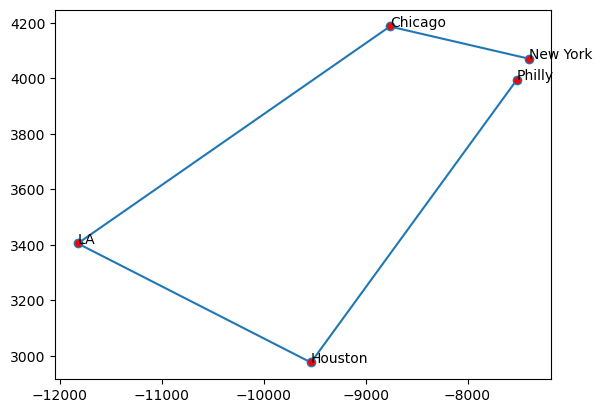

In [21]:
fig, ax1 = plt.subplots(ncols=1)
y=[4071,4187,3405,2976,3995]
x=[-7400,-8762,-11824,-9536,-7516]
n=['New York','Chicago',"LA","Houston","Philly"]
ax1.plot(x, y, marker="o", markerfacecolor="r")
for i, txt in enumerate(n):
    ax1.annotate(txt, (x[i], y[i]))

### TSP with 96 cities
Now we can apply this to a real problem. Note: This took about 15mins to run on my laptop.

In [22]:
NewYork=City(4069, -7392)
LosAngeles=City(3411, -11841)
Chicago=City(4184, -8769)
Miami=City(2578, -8021)
Dallas=City(3279, -9677)
Philadelphia=City(4001, -7513)
Houston=City(2979, -9539)
Atlanta=City(3376, -8442)
Washington=City(3890, -7702)
Boston=City(4232, -7108)
Phoenix=City(3357, -11209)
Seattle=City(4762, -12232)
SanFrancisco=City(3776, -12244)
Detroit=City(4238, -8310)
SanDiego=City(3283, -11712)
Minneapolis=City(4496, -9327)
Tampa=City(2799, -8245)
Denver=City(3976, -10488)
Brooklyn=City(4065, -7395)
Queens=City(4075, -7380)
Riverside=City(3394, -11739)
Baltimore=City(3931, -7661)
LasVegas=City(3623, -11527)
Portland=City(4554, -12265)
SanAntonio=City(2947, -9853)
StLouis=City(3864, -9025)
Sacramento=City(3857, -12147)
Orlando=City(2848, -8134)
SanJose=City(3730, -12185)
Cleveland=City(4148, -8168)
Pittsburgh=City(4044, -7998)
Austin=City(3030, -9775)
Cincinnati=City(3914, -8451)
KansasCity=City(3912, -9455)
Manhattan=City(4078, -7397)
Indianapolis=City(3978, -8615)
Columbus=City(3999, -8299)
Charlotte=City(3521, -8083)
VirginiaBeach=City(3673, -7604)
Bronx=City(4085, -7387)
Milwaukee=City(4306, -8797)
Providence=City(4182, -7142)
Jacksonville=City(3033, -8167)
SaltLakeCity=City(4078, -11193)
Nashville=City(3617, -8678)
Richmond=City(3753, -7748)
Memphis=City(3510, -8998)
Raleigh=City(3583, -7864)
NewOrleans=City(3007, -8993)
Louisville=City(3817, -8565)
OklahomaCity=City(3547, -9751)
Bridgeport=City(4119, -7320)
Buffalo=City(4290, -7885)
FortWorth=City(3278, -9735)
Hartford=City(4177, -7268)
Tucson=City(3215, -11088)
Omaha=City(4126, -9605)
ElPaso=City(3185, -10643)
McAllen=City(2623, -9825)
Albuquerque=City(3511, -10665)
Birmingham=City(3353, -8680)
Sarasota=City(2734, -8254)
Dayton=City(3978, -8420)
Rochester=City(4317, -7762)
Fresno=City(3678, -11979)
Allentown=City(4060, -7548)
Tulsa=City(3613, -9590)
CapeCoral=City(2664, -8200)
Concord=City(3797, -12200)
ColoradoSprings=City(3887, -10476)
Charleston=City(3282, -7996)
Springfield=City(4212, -7254)
GrandRapids=City(4296, -8566)
MissionViejo=City(3361, -11766)
Albany=City(4267, -7380)
Knoxville=City(3597, -8395)
Bakersfield=City(3535, -11904)
Ogden=City(4123, -11197)
BatonRouge=City(3044, -9113)
Akron=City(4108, -8152)
NewHaven=City(4131, -7292)
Columbia=City(3404, -8090)
Mesa=City(3340, -11172)
PalmBay=City(2796, -8066)
Provo=City(4025, -11165)
Worcester=City(4227, -7181)
Murrieta=City(3357, -11719)
Greenville=City(3484, -8236)
Wichita=City(3769, -9734)
Toledo=City(4166, -8358)
StatenIsland=City(4058, -7415)
DesMoines=City(4157, -9361)
LongBeach=City(3380, -11817)
PortStLucie=City(2728, -8039)
Denton=City(3322, -9714)
Madison=City(4308, -8939)
cityList= []
cityList.append(NewYork)
cityList.append(LosAngeles)
cityList.append(Chicago)
cityList.append(Miami)
cityList.append(Dallas)
cityList.append(Philadelphia)
cityList.append(Houston)
cityList.append(Atlanta)
cityList.append(Washington)
cityList.append(Boston)
cityList.append(Phoenix)
cityList.append(Seattle)
cityList.append(SanFrancisco)
cityList.append(Detroit)
cityList.append(SanDiego)
cityList.append(Minneapolis)
cityList.append(Tampa)
cityList.append(Denver)
cityList.append(Brooklyn)
cityList.append(Queens)
cityList.append(Riverside)
cityList.append(Baltimore)
cityList.append(LasVegas)
cityList.append(Portland)
cityList.append(SanAntonio)
cityList.append(StLouis)
cityList.append(Sacramento)
cityList.append(Orlando)
cityList.append(SanJose)
cityList.append(Cleveland)
cityList.append(Pittsburgh)
cityList.append(Austin)
cityList.append(Cincinnati)
cityList.append(KansasCity)
cityList.append(Manhattan)
cityList.append(Indianapolis)
cityList.append(Columbus)
cityList.append(Charlotte)
cityList.append(VirginiaBeach)
cityList.append(Bronx)
cityList.append(Milwaukee)
cityList.append(Providence)
cityList.append(Jacksonville)
cityList.append(SaltLakeCity)
cityList.append(Nashville)
cityList.append(Richmond)
cityList.append(Memphis)
cityList.append(Raleigh)
cityList.append(NewOrleans)
cityList.append(Louisville)
cityList.append(OklahomaCity)
cityList.append(Bridgeport)
cityList.append(Buffalo)
cityList.append(FortWorth)
cityList.append(Hartford)
cityList.append(Tucson)
cityList.append(Omaha)
cityList.append(ElPaso)
cityList.append(McAllen)
cityList.append(Albuquerque)
cityList.append(Birmingham)
cityList.append(Sarasota)
cityList.append(Dayton)
cityList.append(Rochester)
cityList.append(Fresno)
cityList.append(Allentown)
cityList.append(Tulsa)
cityList.append(CapeCoral)
cityList.append(Concord)
cityList.append(ColoradoSprings)
cityList.append(Charleston)
cityList.append(Springfield)
cityList.append(GrandRapids)
cityList.append(MissionViejo)
cityList.append(Albany)
cityList.append(Knoxville)
cityList.append(Bakersfield)
cityList.append(Ogden)
cityList.append(BatonRouge)
cityList.append(Akron)
cityList.append(NewHaven)
cityList.append(Columbia)
cityList.append(Mesa)
cityList.append(PalmBay)
cityList.append(Provo)
cityList.append(Worcester)
cityList.append(Murrieta)
cityList.append(Greenville)
cityList.append(Wichita)
cityList.append(Toledo)
cityList.append(StatenIsland)
cityList.append(DesMoines)
cityList.append(LongBeach)
cityList.append(PortStLucie)
cityList.append(Denton)
cityList.append(Madison)
city_l = cityList
print(len(city_l))

# run GA to solve TSP for 96 cities with 600 indivs, 60 elites, 2% mutation rate, 1000 gens, and max_num_gen_no_improv = 100
bestRoute, bestRoute_list, fitness_record = geneticAlgorithm(population=cityList,
                                                             popSize=600,
                                                             eliteSize=60,
                                                             mutationRate=0.02,
                                                             generations=1000,
                                                             max_num_gen_no_improv=100)

# reporting final distance
best_dist = 1.0 / fitness_record[-1]
print(f'Best distance: {best_dist}')

96
Initial distance: 152722.68061115113
Final distance: 40888.236116562744
Best distance: 40888.236116562744


Initial distance: 160594.62982482207
Final distance: 40191.02545424626


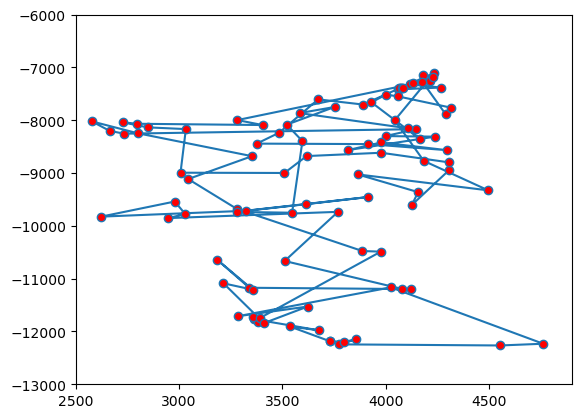

In [23]:
# for plotting:
best_route, best_route_list, fitness_record = geneticAlgorithm(population=cityList,
                                                             popSize=600,
                                                             eliteSize=60,
                                                             mutationRate=0.02,
                                                             generations=1000,
                                                             max_num_gen_no_improv=100)

fig,ax = plt.subplots()
ax.set_xlim([2500,4900])
ax.set_ylim([-13000,-6000])

# extract the x and y coordinates of each city
x=[]
for i in best_route:
    x.append(i.x)
y=[]
for i in best_route:
    y.append(i.y)

# return to the starting city to finish the loop
x.append(x[0])
y.append(y[0])

ax.plot(x, y, marker="o", markerfacecolor="r")

In [24]:
# let's see if different params change the final distance
best_route, best_route_list, fitness_record = geneticAlgorithm(population=cityList,
                                                             popSize=1000,
                                                             eliteSize=60,
                                                             mutationRate=0.02,
                                                             generations=1200,
                                                             max_num_gen_no_improv=200)

Initial distance: 152878.5033338208
Final distance: 43930.32662535969


In [25]:
# what about a higher mutation rate?
best_route, best_route_list, fitness_record = geneticAlgorithm(population=cityList,
                                                             popSize=1000,
                                                             eliteSize=60,
                                                             mutationRate=0.03,
                                                             generations=1200,
                                                             max_num_gen_no_improv=200)

Initial distance: 157929.11913084035
Final distance: 48651.59308498016


In [26]:
# with this setup it appears lower popSize, lower mutation rate, and high gens and patience seem to be the best
best_route, best_route_list, fitness_record = geneticAlgorithm(population=cityList,
                                                             popSize=600,
                                                             eliteSize=60,
                                                             mutationRate=0.02,
                                                             generations=1200,
                                                             max_num_gen_no_improv=200)

Initial distance: 160155.27025000178
Final distance: 36810.90254475808


In [27]:
def make_animation(route_list, fitness_record, Name="Andy Gibson"):
    '''
    Input:  route_list : A list of routes. Its length is the number of generations.
            fitness_record: A list of fitness scores. Its length is also the number of generations.
    '''
    fig,ax = plt.subplots()
    ax.set_xlim([2500,4900])
    ax.set_ylim([-13000,-6000])

    if len(route_list)<=50:
        divisor = 1 
    else:
        divisor= len(route_list)//50
    def initial():
        ax.set_xlim([2500,4900])
        ax.set_ylim([-13000,-6000])
        route_plot, = ax.plot([], [], marker="o", markerfacecolor="r")
        return route_plot,
    def update(n):
        x=[]
        if n >= (len(route_list)//divisor):
            for i in route_list[-1]:
                x.append(i.x)
            y=[]
            for i in route_list[-1]:
                y.append(i.y) 
        else:
            print(f"Producing plot for generation: {int(np.floor(n*divisor))}", end='\r')
            for i in route_list[int(np.floor(n*divisor))]:
                x.append(i.x)
            y=[]
            for i in route_list[int(np.floor(n*divisor))]:
                y.append(i.y)  

        ax = plt.axes(xlim=(2500,4900), ylim=(-13000,-6000))

        route_plot, = ax.plot(x, y, marker="o", markerfacecolor="r")
        ax.set_title(f"Solving traveling salesman problem using genetic algorithms ({Name})")
        route_plot.set_label(f"Generation: {int(np.floor(n*divisor))} Distance : {1 / fitness_record[int(np.floor(n*divisor))]}")
        ax.legend()

        return route_plot,
    anim = animation.FuncAnimation(fig, update, init_func=None, frames=int(len(route_list)//divisor), blit=True)    


    anim.save('animation.gif', fps=4, writer="avconv", codec="libx264",dpi=600)
    

MovieWriter avconv unavailable; using Pillow instead.


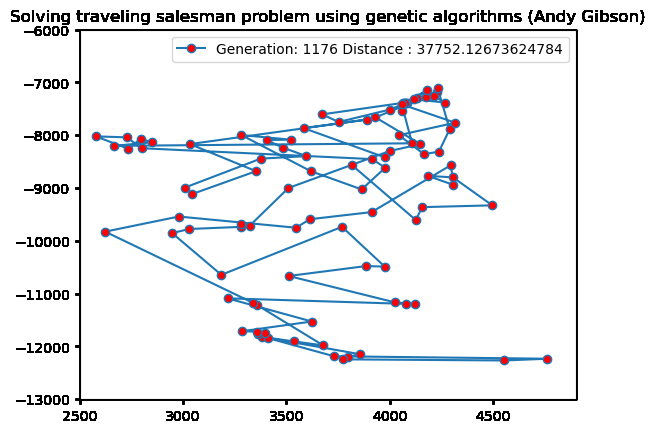

In [28]:
make_animation(best_route_list, fitness_record, Name = "Andy Gibson")

### Comparison with a greedy algorithm
It's interesting to compare a simplistic greedy algorithm that is much less compute-intensive to my lengthy genetic algorithm. As you will see below, with a small list of cities and fewer gens, smaller popSize, etc., the greedy alg far outperforms the GA. However, if you run the GA "overnight" and with optimal params, you will be a shorter route. Below are two different insantiations of a greedy algorithm for TSP.

In [29]:
def greedy(cityList):
    """
    ~ Greediest Neighbor Algorithm for TSP ~
    Greedy algorithm for TSP that always appends the next closest city (sub-optimal). Useful purely for comparison with our GA.
    """
    N = len(cityList)
    visited = [False] * N # populate list of cities to check off, so we only visit each city once
    
    route_ix = [0] # start at the first city
    visited[0] = True # check it off as having been visited
    
    # repeatedly choose the next closest possible city
    while len(route_ix) < N: # keep adding until we reach N cities
        i = route_ix[-1] # define the current city as the last one added to the path
        best_j = -1 # initialize the current best city
        best_d = float('inf') # and their distance
        # calculates the euclidean distance between current city and possible next cities
        for k in range(N):
            if not visited[k]: # prevent visiting a city twice
                d = cityList[i].distance(cityList[k]) # compute distance from current city i to potential next cities k
                if d < best_d: # store that distance if it's smaller
                    best_d = d # new best distance
                    best_j = k # and city

        route_ix.append(best_j) # append the nearest unvisited city to the route
        visited[best_j] = True # save that we visited it

    min_route = [cityList[i] for i in route_ix] # convert from indicies back to cities with list comp

    mindist = Fitness(min_route).routeDistance() # calculate the length of the entire loop
    
    return mindist, min_route
    
mindist, min_route = greedy(city_l)     
print("The shortest route distance using a greedy algorithm : ", mindist)

The shortest route distance using a greedy algorithm :  26479.40513790805


In [30]:
def greedy(cityList):
    """
    ~ Greedier Neighbor Algorithm for TSP ~
    This algorithm repeatedly tests each city as an ideal starting point and then chooses the next closest city until the loop is completed. 
    I was advised that this would be a better greedy algorithm than just starting at the first city every time.

    Greediest alg greediness > greedier alg greediness
    """
    N = len(cityList)

    best_dist = float('inf') # define running best distance and route metrics
    best_route = None

    # test out each option for a starting city
    for start in range(N):
        visited = [False] * N # make sure we can't visit a city twice (except the start)
        route_ix = [start] # store ixs of visted cities in order
        visited[start] = True # check off the start as having been visited

        # repeatedly choose the next closest possible city
        while len(route_ix) < N: # go through all cities in N
            i = route_ix[-1] # set the current index at the previous city visited
            best_j = -1 # initialize current best city
            best_d = float('inf') # and its distance
            # calculates the euclidean distance between current city and possible next cities
            for k in range(N):
                if not visited[k]: # prevent visiting a city twice
                    d = cityList[i].distance(cityList[k])  # compute distance from current city i to potential next cities k
                    if d < best_d: # store that distance if it's smaller
                        best_d = d # new best distance
                        best_j = k # and city
                        
            route_ix.append(best_j) # append the nearest unvisited city to the route
            visited[best_j] = True # save that we visited it

        # build route and score (includes return to start via Fitness)
        route = [cityList[i] for i in route_ix] # convert from indicies back to cities with list comp
        
        dist = Fitness(route).routeDistance() # calculate the length of the entire loop

        # save this starting city only if the route associated with it is better than all previous ones
        if dist < best_dist:
            best_dist = dist
            best_route = route

    return best_dist, best_route

mindist, min_route = greedy(city_l)
print("The shortest route distance using a greedy algorithm :", mindist)

The shortest route distance using a greedy algorithm : 22467.238194193524
